In [1]:
%load_ext autoreload  
%autoreload 2  
!hostname  
!pwd  
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

oliva-titanrtx-2.csail.mit.edu
/data/vision/phillipi/akumar01/synthetic-mdps/src
/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial  

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn

import optax

In [4]:
from util import load_pkl, save_pkl
from compile_experiment import envs_mujoco, envs_procgen, envs_dm_control

In [5]:
data_dir = "~/synthetic-mdps-data/"
data_dir = os.path.expanduser(data_dir)

In [9]:
def smooth_signal(x, window=100):
    kernel = np.ones(window) / window
    # pad_width = window // 2
    # padded_signal = np.pad(x, pad_width, mode='edge')
    # return np.convolve(padded_signal, kernel, mode='valid')
    return np.convolve(x, kernel, mode='same')

def exponential_smoothing(x, alpha=0.9):
    smoothed_signal = np.zeros_like(x)
    smoothed_signal[0] = x[0]
    for t in range(1, len(x)):
        smoothed_signal[t] = (1-alpha) * x[t] + alpha * smoothed_signal[t-1]
    return smoothed_signal

  0%|          | 0/11 [00:00<?, ?it/s]

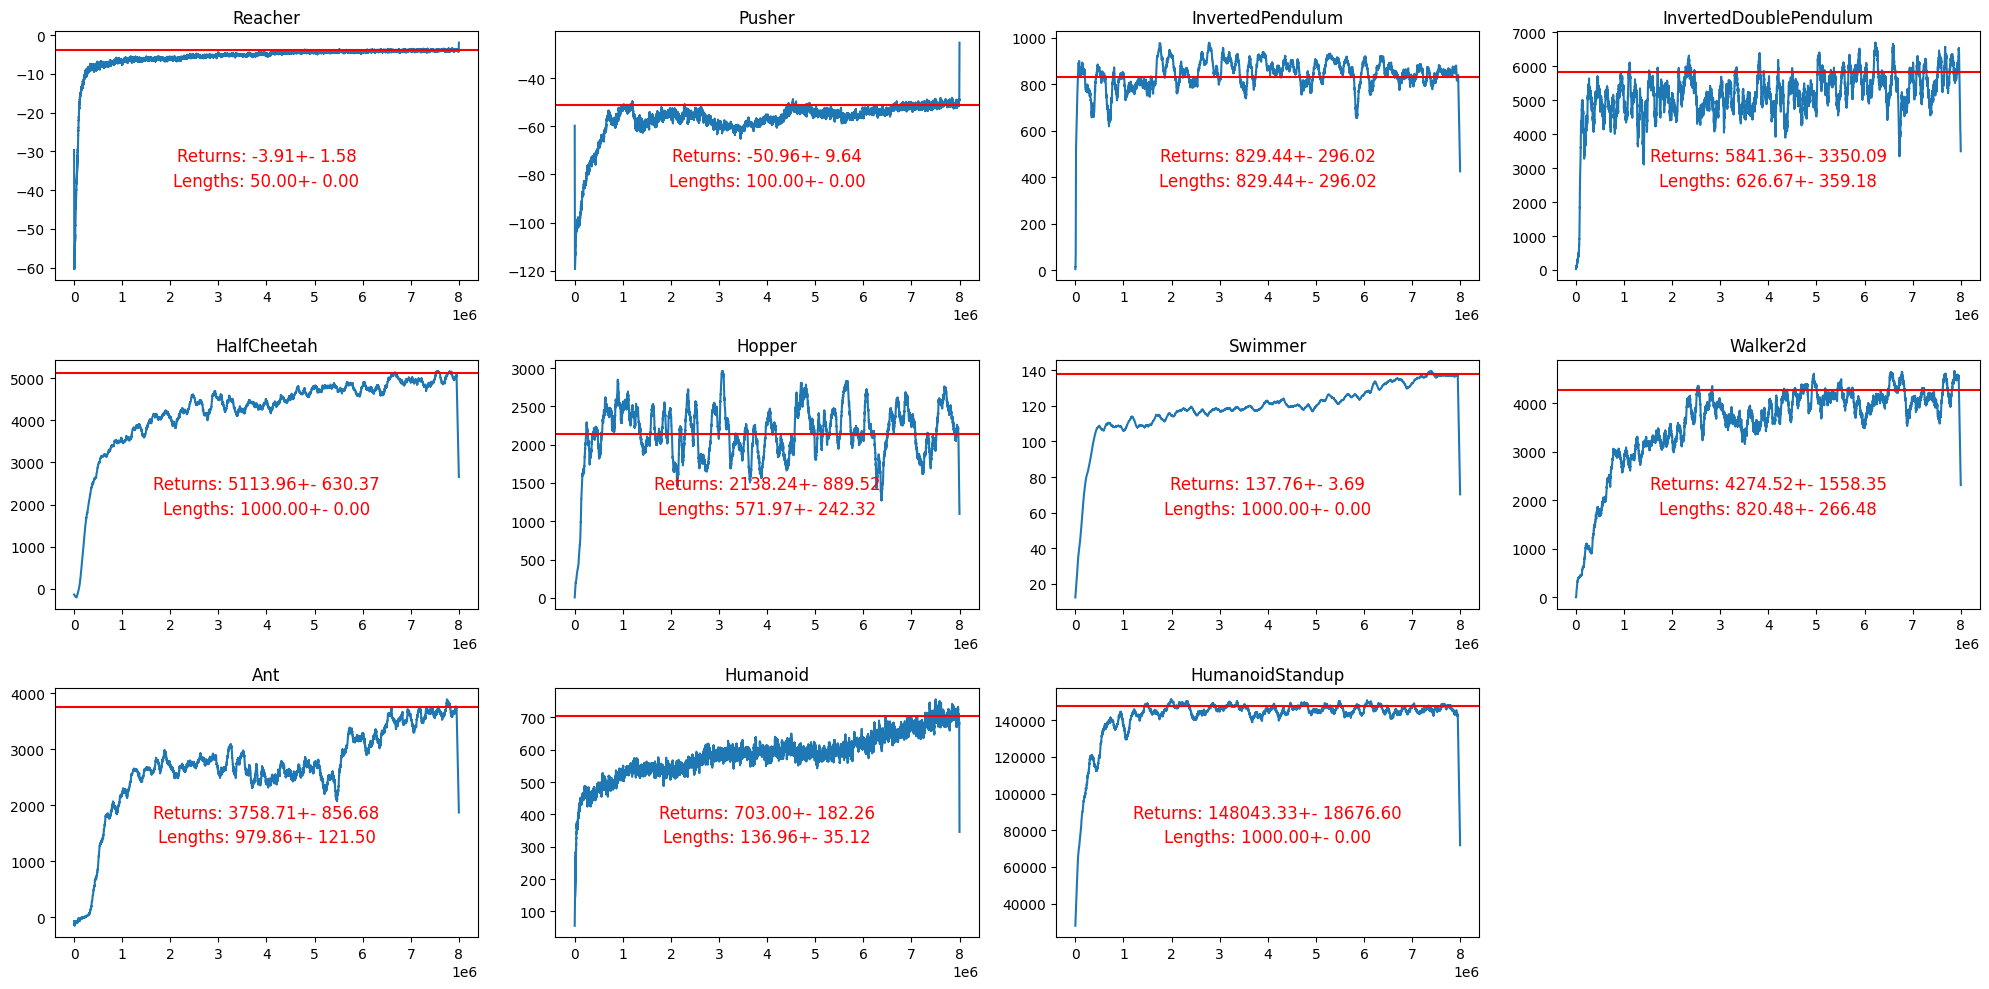

In [7]:
plt.figure(figsize=(20, 10))
for i, env in enumerate(tqdm(envs_mujoco)):
    plt.subplot(3, 4, i+1)
    stats = load_pkl(f"{data_dir}/datasets/mujoco/{env}", "train_stats")
    x = np.array(stats['global_step']).reshape(-1)
    y = np.array(stats['episode_return']).reshape(-1)
    y = smooth_signal(y, window=100)
    plt.plot(x, y)
    
    stats = load_pkl(f"{data_dir}/datasets/mujoco/{env}", "dataset_stats")
    returns = np.array(stats['episode_return']).reshape(-1)
    lengths = np.array(stats['episode_length']).reshape(-1)
    plt.text(0.5, 0.5, f"Returns: {np.mean(returns):.2f}+- {np.std(returns):.2f}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes, c='r')
    plt.text(0.5, 0.4, f"Lengths: {np.mean(lengths):.2f}+- {np.std(lengths):.2f}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes, c='r')
    plt.axhline(np.mean(returns), color='r')
    plt.title(env)
    
plt.tight_layout()
plt.show()

  0%|          | 0/49 [00:00<?, ?it/s]

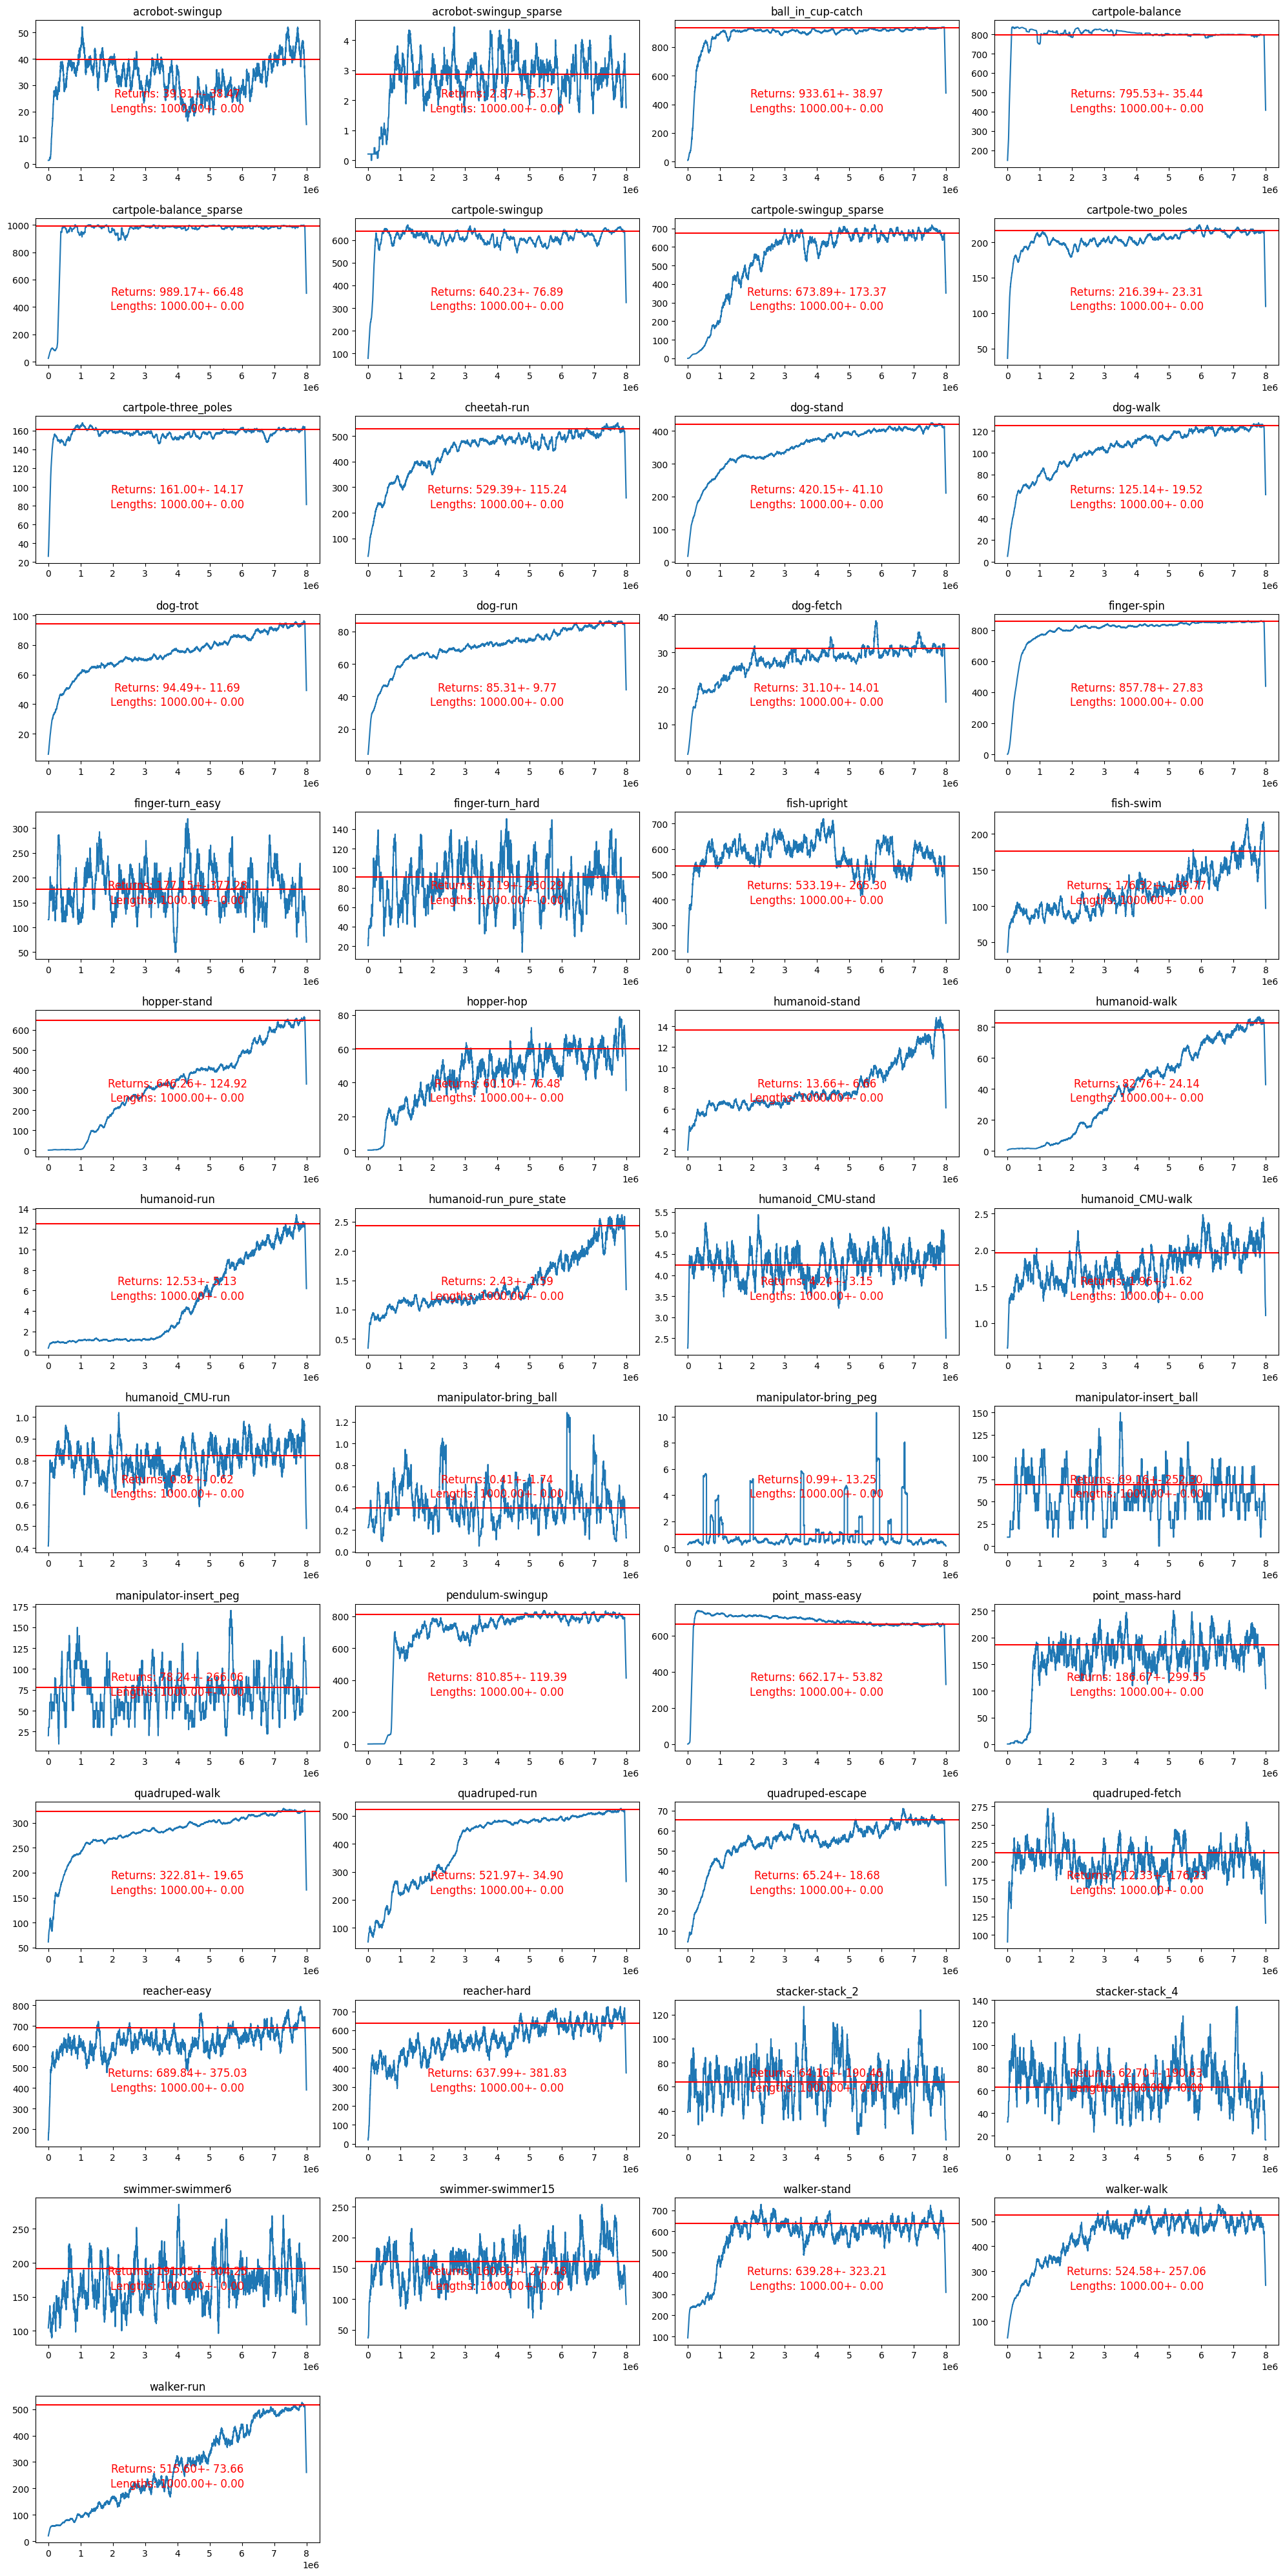

In [9]:
plt.figure(figsize=(20, 40))
for i, env in enumerate(tqdm(envs_dm_control)):
    plt.subplot(13, 4, i+1)
    stats = load_pkl(f"{data_dir}/datasets/dm_control/{env}", "train_stats")
    x = np.array(stats['global_step']).reshape(-1)
    y = np.array(stats['episode_return']).reshape(-1)
    y = smooth_signal(y, window=100)
    plt.plot(x, y)
    
    stats = load_pkl(f"{data_dir}/datasets/dm_control/{env}", "dataset_stats")
    returns = np.array(stats['episode_return']).reshape(-1)
    lengths = np.array(stats['episode_length']).reshape(-1)
    plt.text(0.5, 0.5, f"Returns: {np.mean(returns):.2f}+- {np.std(returns):.2f}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes, c='r')
    plt.text(0.5, 0.4, f"Lengths: {np.mean(lengths):.2f}+- {np.std(lengths):.2f}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes, c='r')
    plt.axhline(np.mean(returns), color='r')
    
    plt.title(env)
    
    
plt.tight_layout()
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

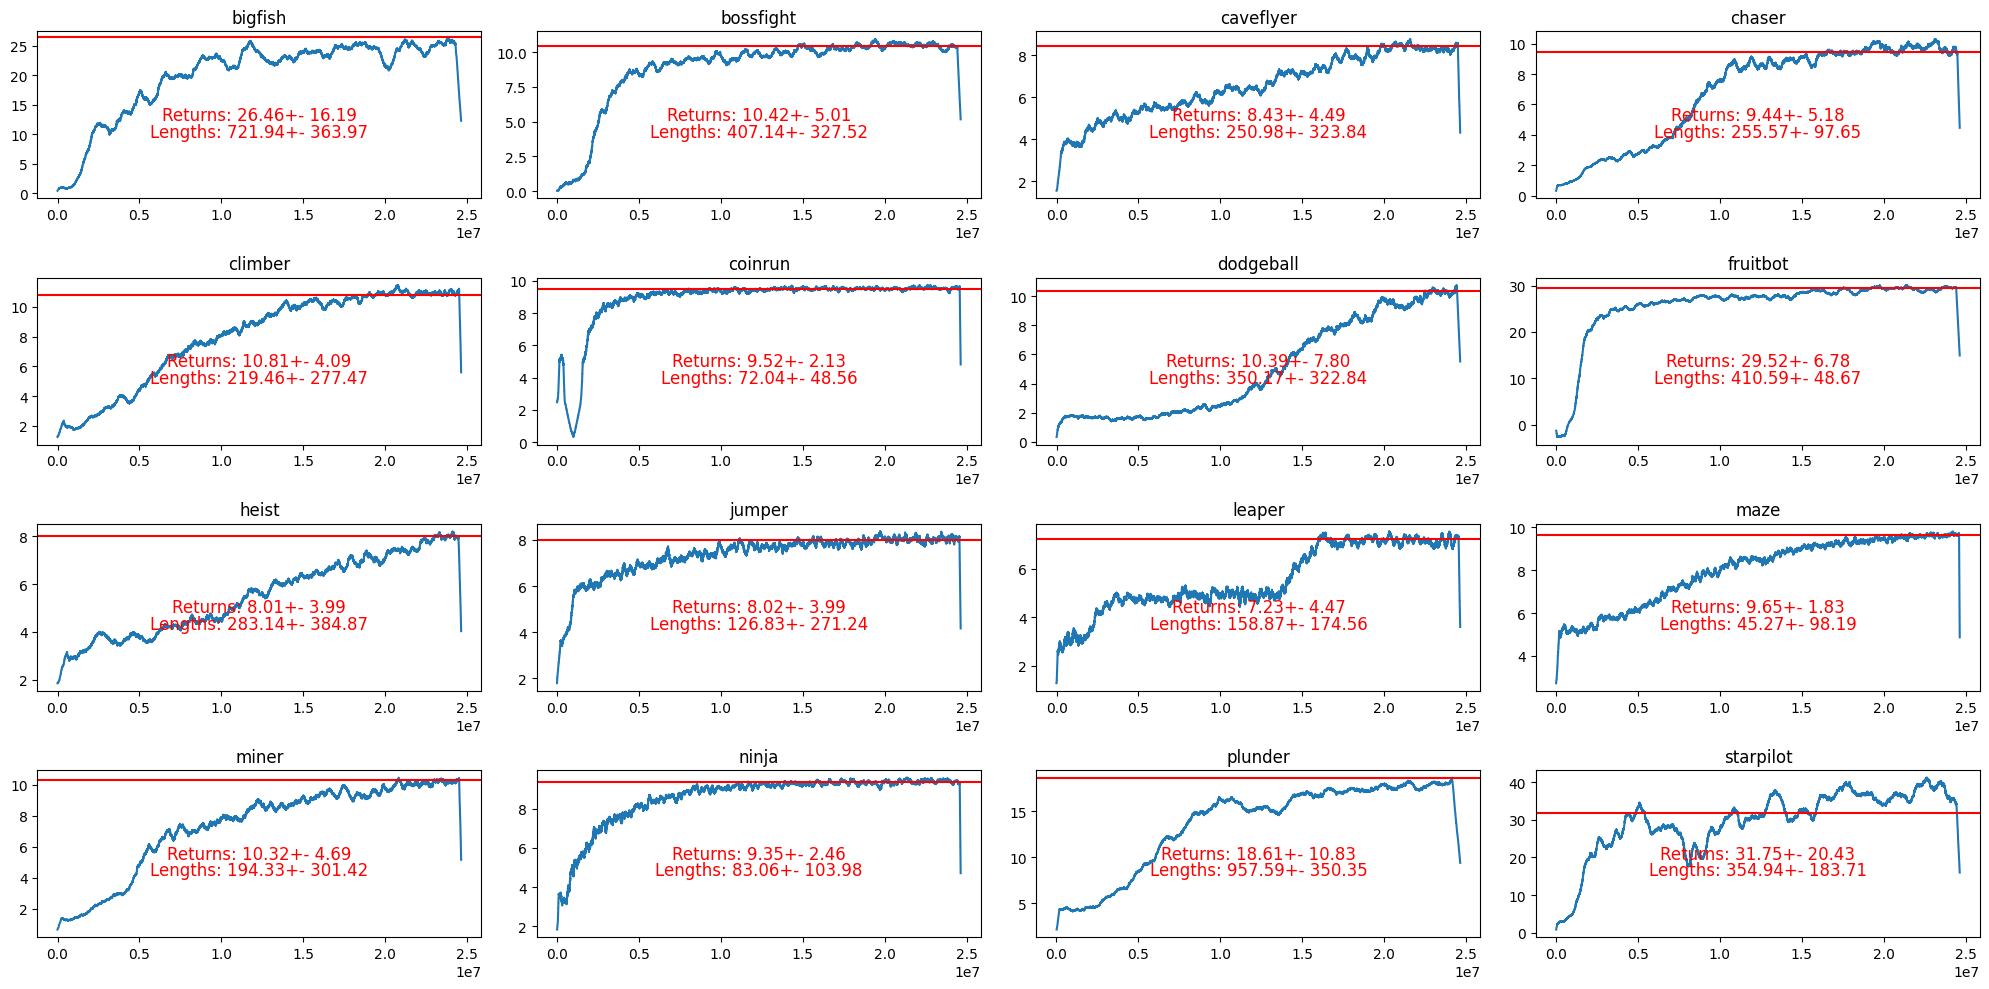

In [10]:
plt.figure(figsize=(20, 10))
for i, env in enumerate(tqdm(envs_procgen)):
    plt.subplot(4, 4, i+1)
    stats = load_pkl(f"{data_dir}/datasets/procgen/{env}", "train_stats")
    x = np.array(stats['global_step']).reshape(-1)
    y = np.array(stats['episode_return']).reshape(-1)
    y = smooth_signal(y, window=1000)
    plt.plot(x, y)
    
    
    stats = load_pkl(f"{data_dir}/datasets/procgen/{env}", "dataset_stats")
    returns = np.array(stats['episode_return']).reshape(-1)
    lengths = np.array(stats['episode_length']).reshape(-1)
    plt.text(0.5, 0.5, f"Returns: {np.mean(returns):.2f}+- {np.std(returns):.2f}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes, c='r')
    plt.text(0.5, 0.4, f"Lengths: {np.mean(lengths):.2f}+- {np.std(lengths):.2f}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes, c='r')
    plt.axhline(np.mean(returns), color='r')
    plt.title(env)

    
plt.tight_layout()
plt.show()
    

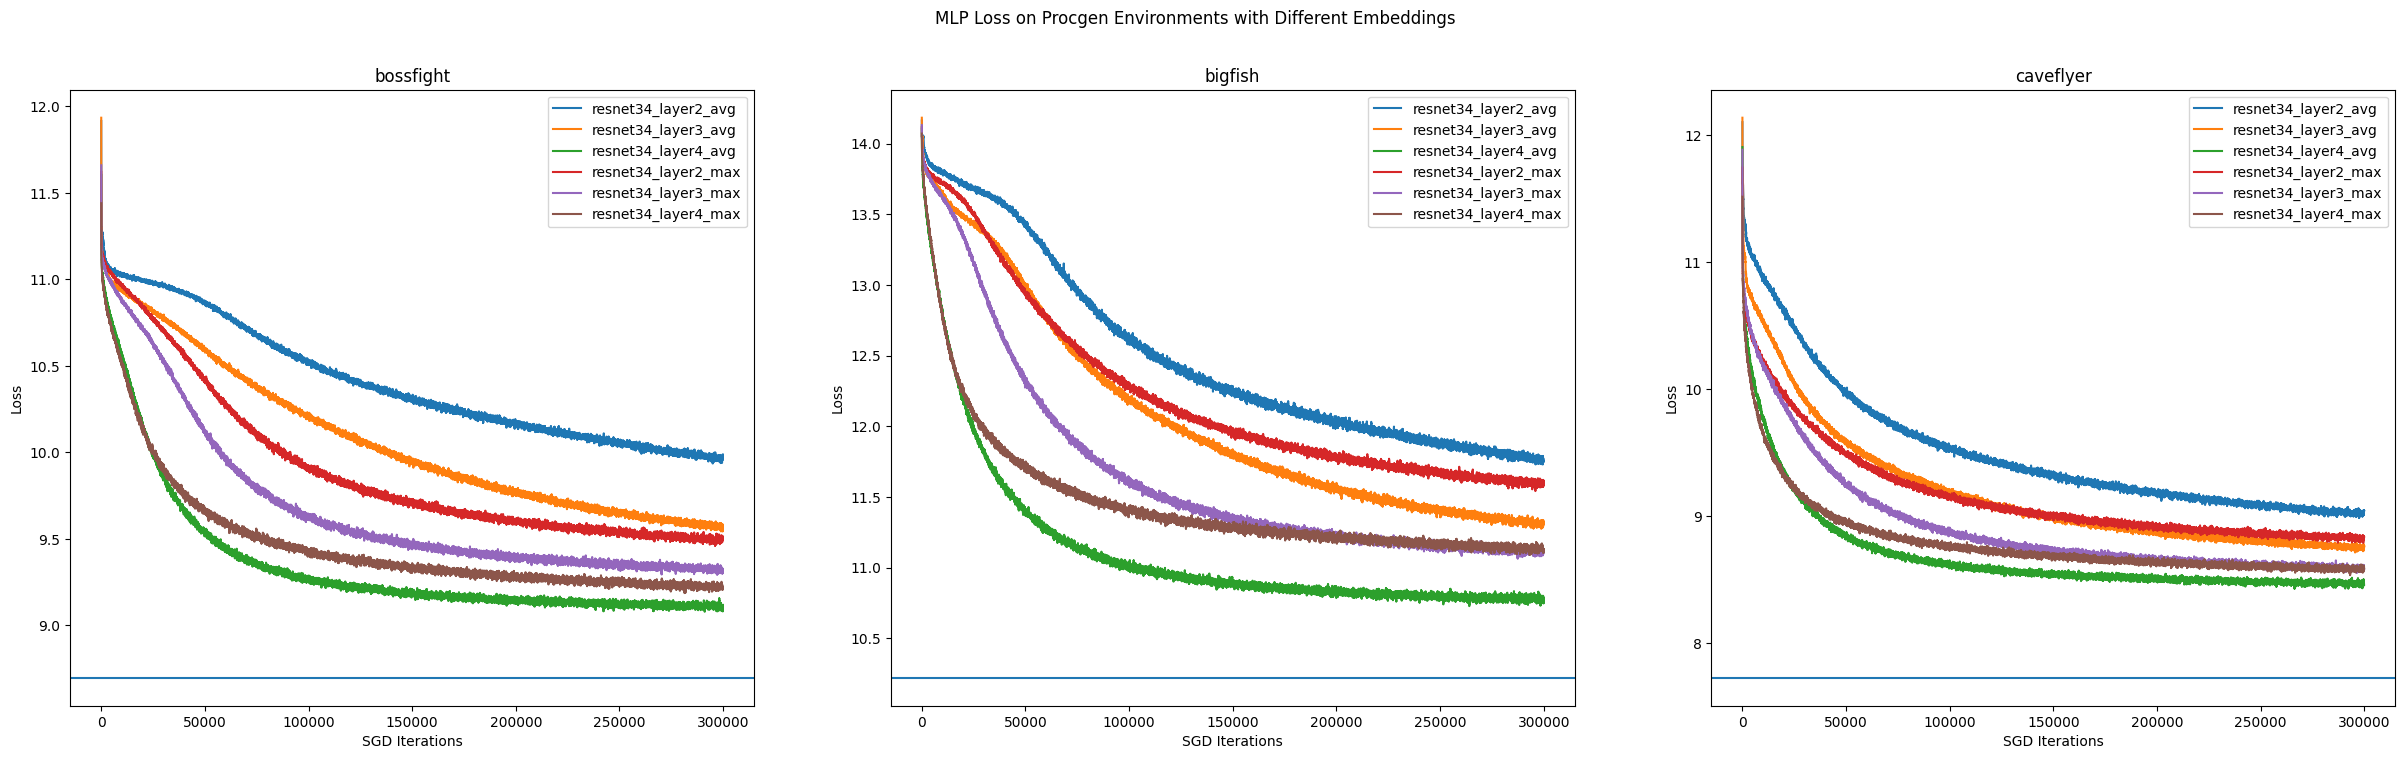

In [46]:
plt.figure(figsize=(30, 8))
for i, env_id in enumerate(['bossfight', 'bigfish', 'caveflyer']):
    plt.subplot(1, 3, i+1)
    for embed_name in ["resnet34_layer2_avg", "resnet34_layer3_avg", "resnet34_layer4_avg",
                       "resnet34_layer2_max", "resnet34_layer3_max", "resnet34_layer4_max"]:
        with open(f"/data/vision/phillipi/akumar01/synthetic-mdps-data/datasets_temp/procgen/{env_id}/{embed_name}/train_stats.pkl", "rb") as f:
            ts = pickle.load(f)
            y = ts['ce']/1024
            y = np.convolve(y, np.ones(100)/100, mode='valid')
            plt.plot(np.e**y, label=embed_name)
    plt.axhline(np.e**ts['entr_tar'].mean())
    plt.title(env_id)
    plt.ylabel("Loss")
    plt.xlabel("SGD Iterations")
    plt.legend()

plt.suptitle("MLP Loss on Procgen Environments with Different Embeddings")
plt.show()


In [33]:
from compile_experiment import envs_mujoco
import jax
import numpy as np

  0%|          | 0/22 [00:00<?, ?it/s]

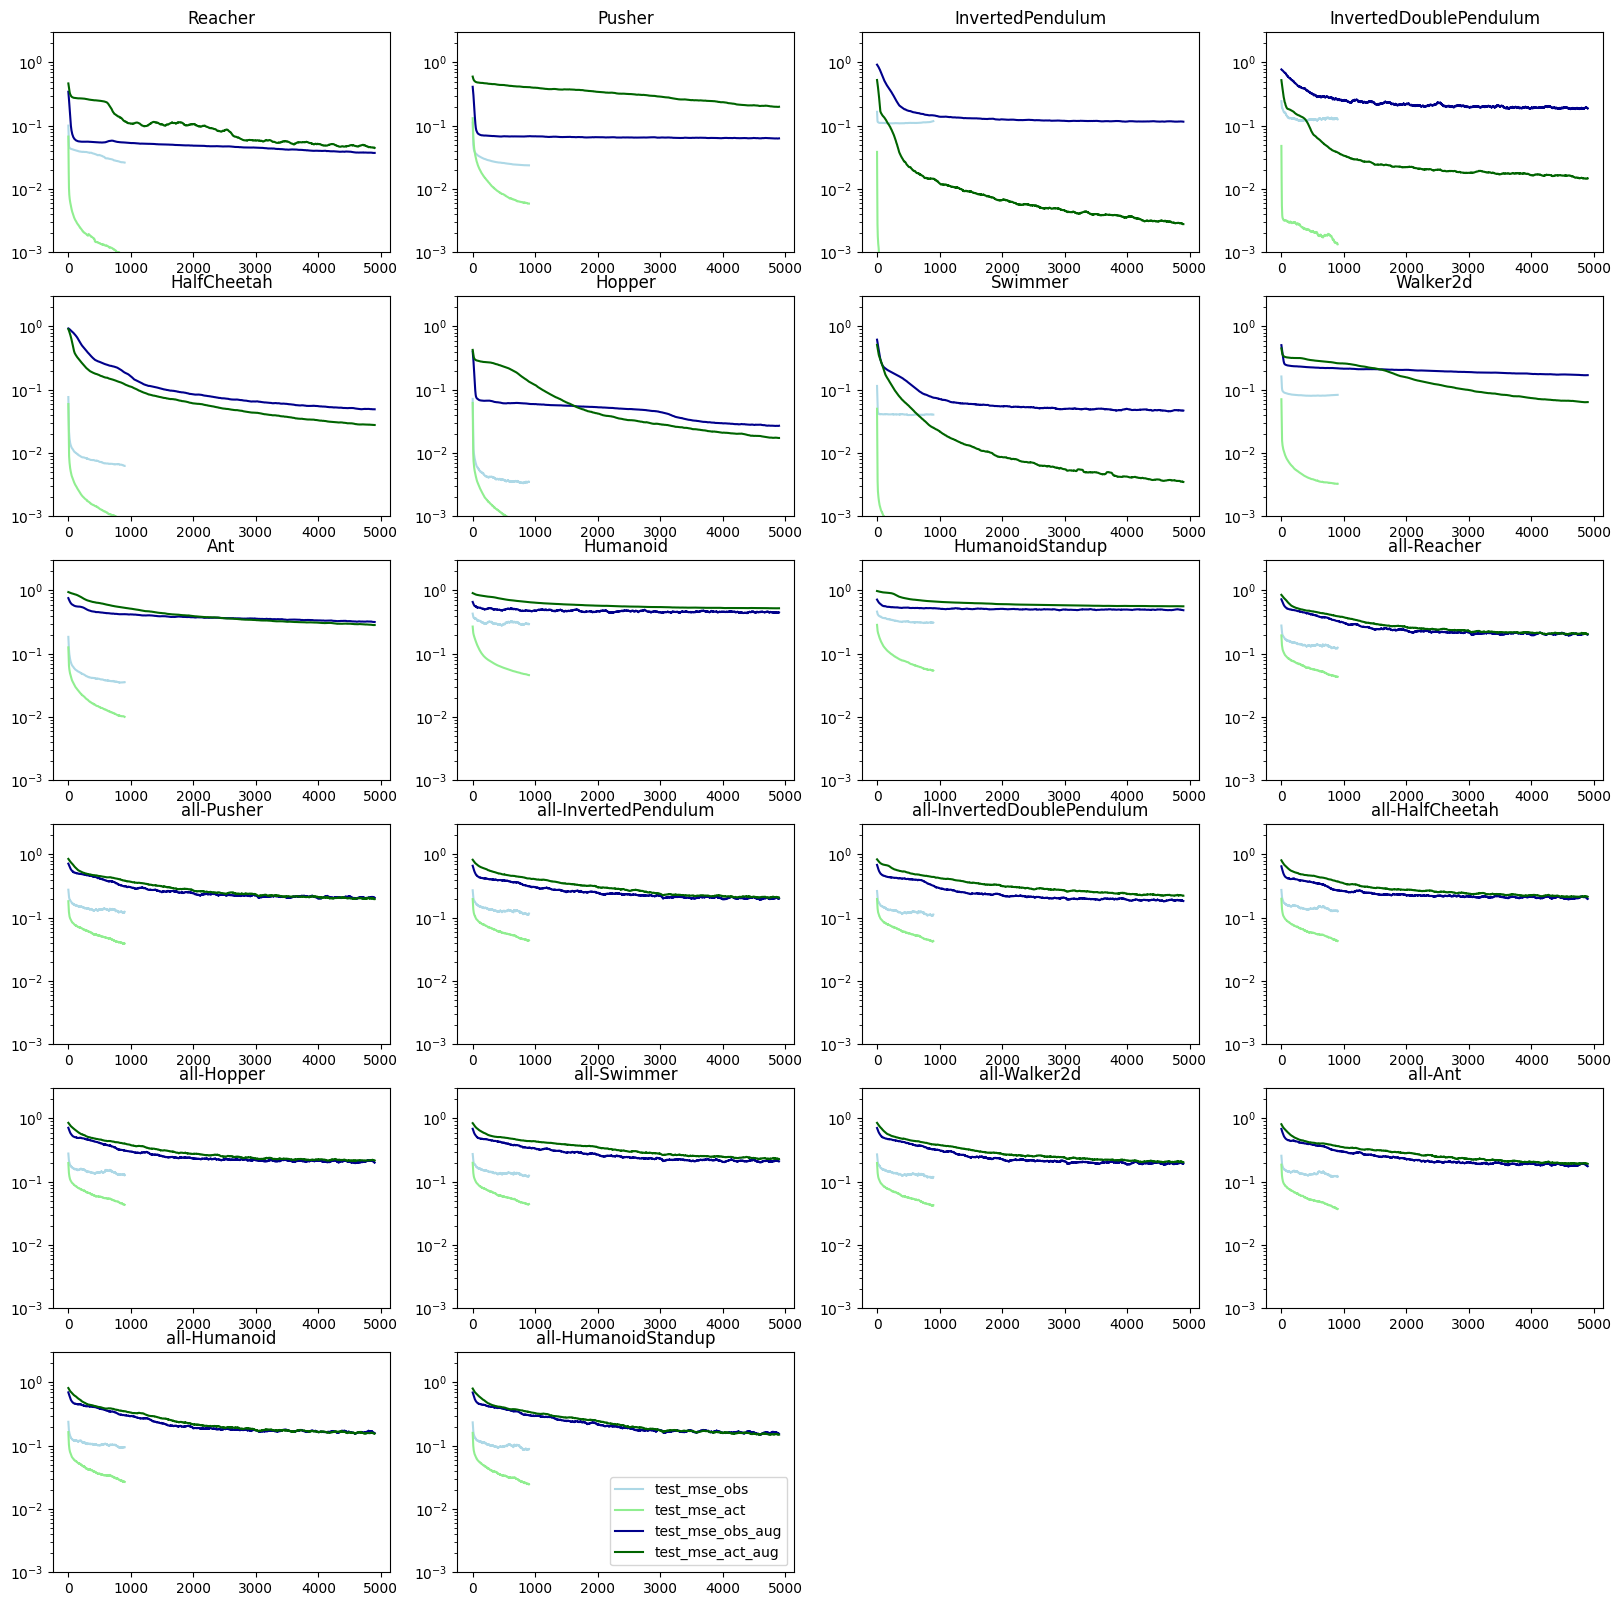

In [111]:
plt.figure(figsize=(20, 20))
envs_mujoco_gato = [f"all-{env_id}" for env_id in envs_mujoco]
for i, env_id in enumerate(tqdm(envs_mujoco + envs_mujoco_gato)):
    plt.subplot(6, 4, i+1)

    data_type = 'test'
    
    win_size = 100
    
    # reduction1 = lambda x: x[-500:].mean(axis=0)
    reduction1 = lambda x: x[:, -100:].mean(axis=-1)
    reduction = lambda x: np.convolve(reduction1(x), np.ones(win_size)/win_size, mode='valid')
    
    metrics = load_pkl(f"{data_dir}/train_bc/{env_id}", f"metrics_{data_type}")
    a = reduction(metrics[f'mse_obs'])
    plt.plot(a, label=f"{data_type}_mse_obs", c="lightblue")
    a = reduction(metrics[f'mse_act'])
    plt.plot(a, label=f"{data_type}_mse_act", c="lightgreen")

    metrics = load_pkl(f"{data_dir}/train_bc_aug/{env_id}", f"metrics_{data_type}")
    a = reduction(metrics[f'mse_obs'])
    plt.plot(a, label=f"{data_type}_mse_obs_aug", c="darkblue")
    a = reduction(metrics[f'mse_act'])
    plt.plot(a, label=f"{data_type}_mse_act_aug", c="darkgreen")

    plt.yscale('log')
    plt.title(env_id)
    plt.ylim(1e-3, 3)

plt.legend()
plt.show()



In [13]:
import jax
rng = jax.random.PRNGKey(0)
A = jax.random.normal(rng, (64, 64))/np.sqrt(64)

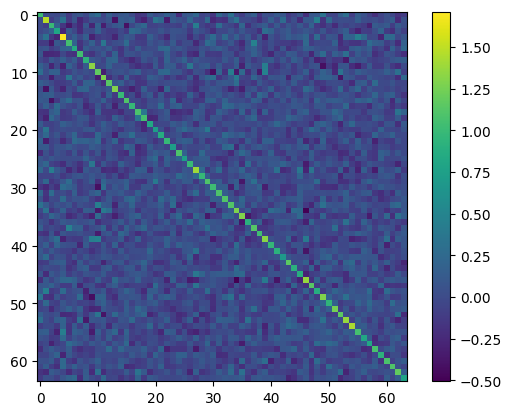

In [17]:
plt.imshow(A@A.T)
plt.colorbar()

In [19]:
from icl_bc_ed import construct_dataset, sample_batch_from_dataset, augment_batch
from agents.regular_transformer import BCTransformer

In [23]:
agent = BCTransformer(d_obs=128, d_act=21,
                      n_layers=4, n_heads=8, d_embd=256, ctx_len=512)


In [112]:
dataset_train, dataset_test = construct_dataset([f"{data_dir}/datasets/mujoco/Reacher/dataset.pkl"], [], 128, 21, percent_dataset=(0.25, 1.0))

Found 1 datasets
Loading dataset from /data/vision/phillipi/akumar01/synthetic-mdps-data/datasets/mujoco/Reacher/dataset.pkl
Dataset shape: {'act': ((64, 131072, 2), dtype('float32')), 'done': ((64, 131072), dtype('float32')), 'obs': ((64, 131072, 11), dtype('float32')), 'rew': ((64, 131072), dtype('float32')), 'time': ((64, 131072), dtype('int32'))}


In [120]:
rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
batch = sample_batch_from_dataset(rng, dataset_train, 64, 512, 512)
rng, _rng = jax.random.split(rng)
batch = augment_batch(rng, batch, 0)

In [121]:
agent_params = load_pkl(f"{data_dir}/train_bc_aug/all-Reacher/", "ckpt_0050000")['params']

In [122]:
result = jax.vmap(agent.apply, in_axes=(None, 0, 0, 0))(agent_params, batch['obs'], batch['act'], batch['time'])

In [123]:
result.keys()

dict_keys(['act_now', 'act_now_pred', 'act_nxt', 'act_prv', 'obs_now', 'obs_nxt', 'obs_nxt_pred', 'obs_prv'])

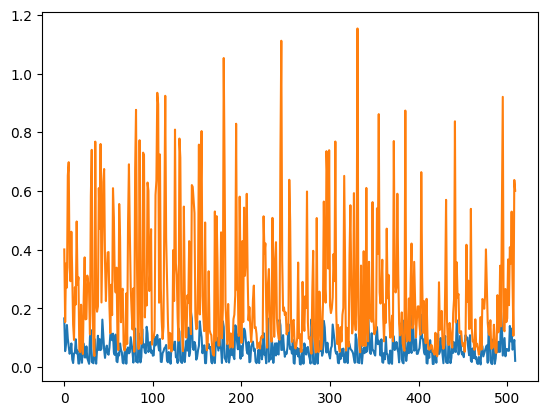

In [124]:
plt.plot(((result['obs_nxt'] - result['obs_nxt_pred'])**2).mean(axis=-1).mean(axis=0))
plt.plot(((result['act_now'] - result['act_now_pred'])**2).mean(axis=-1).mean(axis=0))


In [36]:
batch['obs'].shape

(64, 512, 128)

In [71]:
rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
batch = sample_batch_from_dataset(rng, dataset_train, 64, 512, 512)
rng, _rng = jax.random.split(rng)


In [94]:
from sklearn.decomposition import PCA
def viz_batch(batch):
    print(jax.tree_map(lambda x: x.shape, batch))
    batch = jax.tree_map(lambda x: x[:, :64], batch)
    print(jax.tree_map(lambda x: x.shape, batch))
    B, T, _ = batch['obs'].shape
    obs, act = batch['obs'], batch['act']
    obs_flat, act_flat = rearrange(obs, 'B T D -> (B T) D'), rearrange(act, 'B T D -> (B T) D')

    pca_obs, pca_act = PCA(n_components=2).fit(obs_flat), PCA(n_components=2).fit(act_flat)
    obs_2d_flat, act_2d_flat = pca_obs.transform(obs_flat), pca_act.transform(act_flat)
    obs_2d, act_2d = rearrange(obs_2d_flat, '(B T) D -> B T D', B=B, T=T), rearrange(act_2d_flat, '(B T) D -> B T D', B=B, T=T)

    for i in range(5):
        plt.plot(obs_2d[i, :, 0], obs_2d[i, :, 1])
        # plt.plot(act_2d[i, :, 0], act_2d[i, :, 1])

    plt.show()


{'act': (64, 512, 21), 'done': (64, 512), 'obs': (64, 512, 128), 'rew': (64, 512), 'time': (64, 512)}
{'act': (64, 64, 21), 'done': (64, 64), 'obs': (64, 64, 128), 'rew': (64, 64), 'time': (64, 64)}


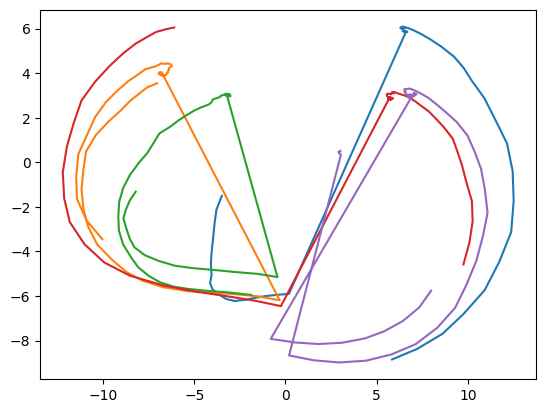

{'act': (64, 512, 21), 'done': (64, 512), 'obs': (64, 512, 128), 'rew': (64, 512), 'time': (64, 512)}
{'act': (64, 64, 21), 'done': (64, 64), 'obs': (64, 64, 128), 'rew': (64, 64), 'time': (64, 64)}


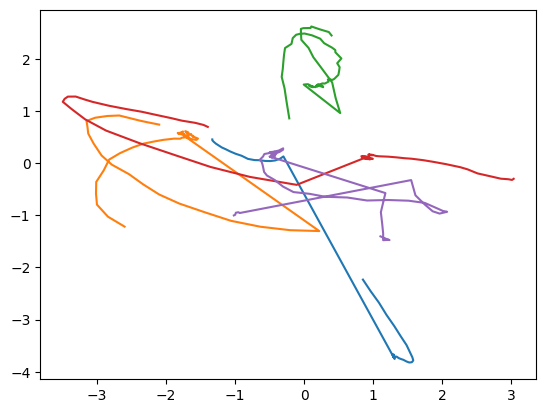

{'act': (64, 512, 21), 'done': (64, 512), 'obs': (64, 512, 128), 'rew': (64, 512), 'time': (64, 512)}
{'act': (64, 64, 21), 'done': (64, 64), 'obs': (64, 64, 128), 'rew': (64, 64), 'time': (64, 64)}


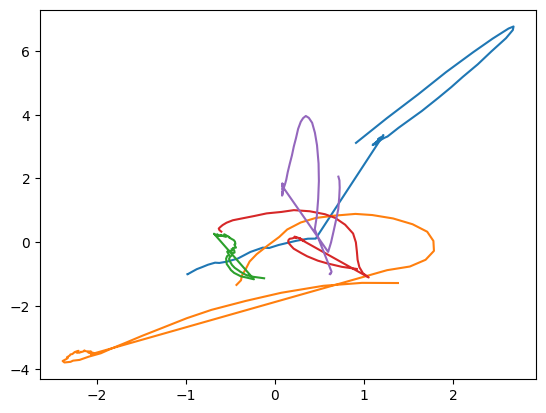

In [95]:
viz_batch(batch)
viz_batch(augment_batch(rng, batch, 1000000, mat_type='orthogonal'))
viz_batch(augment_batch(rng, batch, 1000000, mat_type='gaussian'))


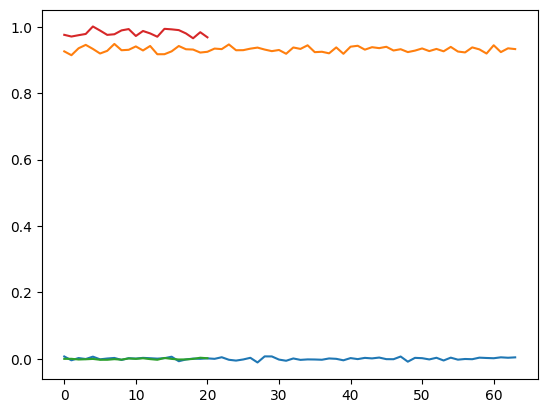

In [249]:
plt.plot(batch['obs'].mean(axis=(0, 1)))
plt.plot(batch['obs'].var(axis=(0, 1)))
plt.plot(batch['act'].mean(axis=(0, 1)))
plt.plot(batch['act'].var(axis=(0, 1)))

In [178]:
rng = jax.random.PRNGKey(0)
x = jax.random.normal(rng, (10000, 32))

A = jax.random.orthogonal(rng, 32)[:8, :32]

y = (x@A.T)/np.sqrt(np.diag(A@A.T))


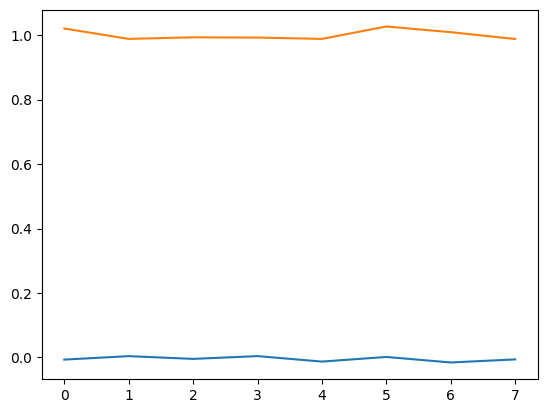

In [179]:
plt.plot(y.mean(axis=0))
plt.plot(y.var(axis=0))

In [38]:
from compile_experiment import envs_mujoco, envs_csmdp, envs_dsmdp

In [48]:
data = {}
for env_id in tqdm(envs_mujoco):
    data[env_id] = {}
    for pre in ['scratch', 'oracle', 'oracle_aug', 'gato', 'gato_aug']:
        data[env_id][pre] = load_pkl(f"{data_dir}/test_bc/mujoco/{env_id}/{pre}", "metrics_before")
    for pre in envs_csmdp + [f"{i}_aug" for i in envs_csmdp]:
        try:
            data[env_id][f"{pre}"] = load_pkl(f"{data_dir}/test_bc/mujoco/{env_id}/{pre}", "metrics_before")
        except:
            data[env_id][f"{pre}"] = None
            print(f"Failed to load {pre} for {env_id}")
    for pre in envs_dsmdp + [f"{i}_aug" for i in envs_dsmdp]:
        try:
            data[env_id][f"{pre}"] = load_pkl(f"{data_dir}/test_bc/mujoco/{env_id}/{pre}", "metrics_before")
        except:
            data[env_id][f"{pre}"] = None
            print(f"Failed to load {pre} for {env_id}")
        

  0%|          | 0/11 [00:00<?, ?it/s]

Failed to load name=dsmdp;i_d=0;i_s=4;t_a=0;t_s=3;o_d=0;tl=16 for Reacher
Failed to load name=dsmdp;i_d=1;i_s=3;t_a=2;t_s=3;o_d=0;tl=1_aug for Reacher
Failed to load name=dsmdp;i_d=4;i_s=0;t_a=2;t_s=2;o_d=0;tl=64_aug for Reacher
Failed to load name=dsmdp;i_d=0;i_s=4;t_a=0;t_s=3;o_d=0;tl=16 for Pusher
Failed to load name=dsmdp;i_d=1;i_s=3;t_a=2;t_s=3;o_d=0;tl=1_aug for Pusher
Failed to load name=dsmdp;i_d=4;i_s=0;t_a=2;t_s=2;o_d=0;tl=64_aug for Pusher
Failed to load name=dsmdp;i_d=0;i_s=4;t_a=0;t_s=3;o_d=0;tl=16 for InvertedPendulum
Failed to load name=dsmdp;i_d=1;i_s=3;t_a=2;t_s=3;o_d=0;tl=1_aug for InvertedPendulum
Failed to load name=dsmdp;i_d=4;i_s=0;t_a=2;t_s=2;o_d=0;tl=64_aug for InvertedPendulum
Failed to load name=dsmdp;i_d=0;i_s=4;t_a=0;t_s=3;o_d=0;tl=16 for InvertedDoublePendulum
Failed to load name=dsmdp;i_d=1;i_s=3;t_a=2;t_s=3;o_d=0;tl=1_aug for InvertedDoublePendulum
Failed to load name=dsmdp;i_d=4;i_s=0;t_a=2;t_s=2;o_d=0;tl=64_aug for InvertedDoublePendulum
Failed to load 

  0%|          | 0/11 [00:00<?, ?it/s]

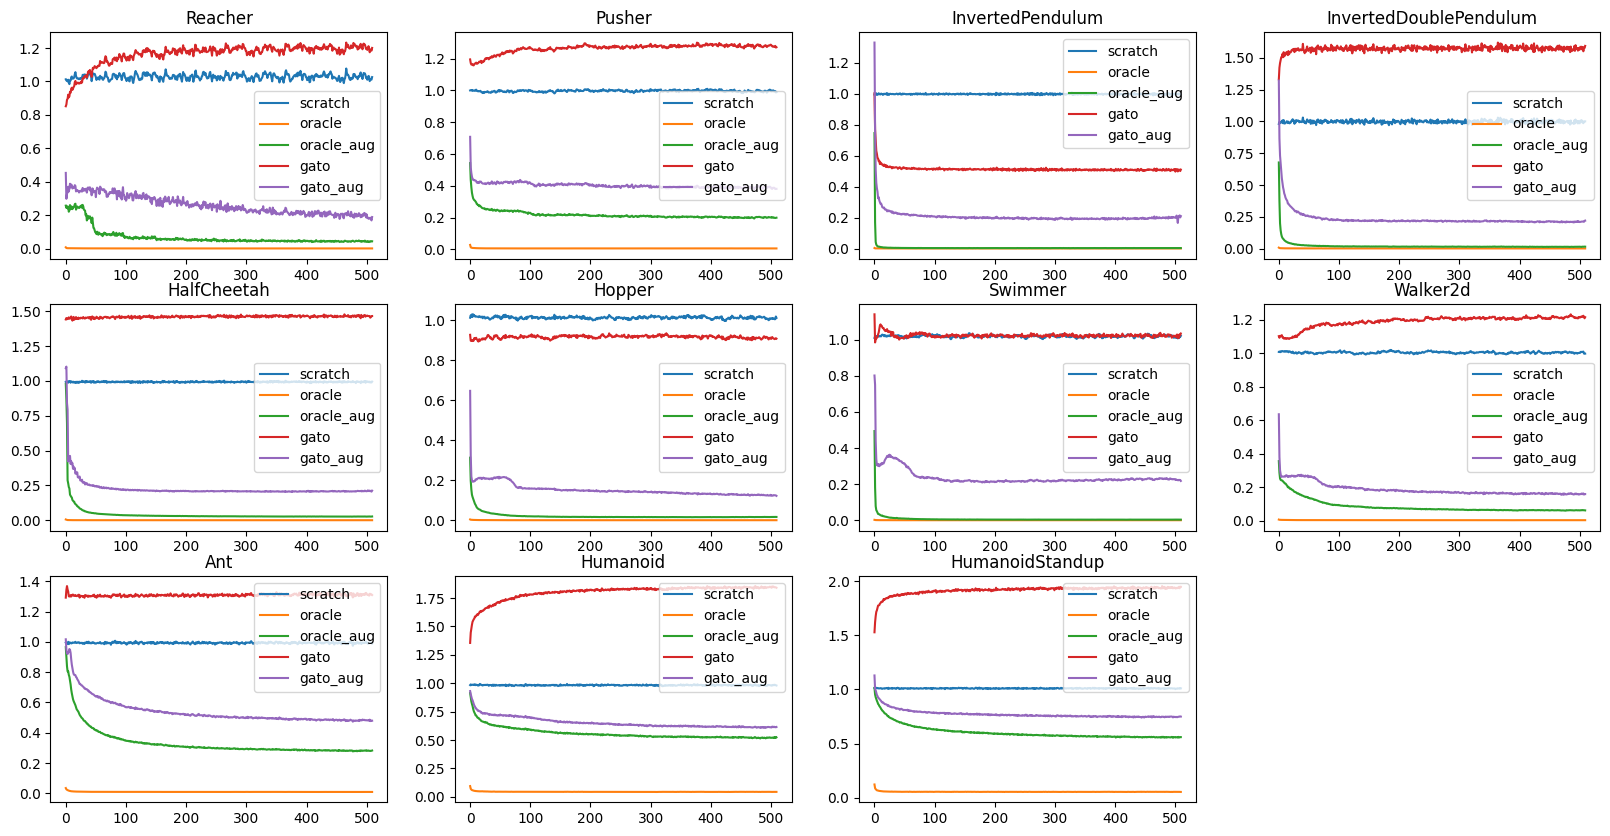

In [50]:
plt.figure(figsize=(20, 10))

for i_plt, env_id in enumerate(tqdm(envs_mujoco)):
    plt.subplot(3, 4, i_plt+1)
    
    a = data[env_id]['scratch']
    plt.plot(a['mse_act'].mean(axis=0), label='scratch')

    a = data[env_id]['oracle']
    plt.plot(a['mse_act'].mean(axis=0), label='oracle')
    a = data[env_id]['oracle_aug']
    plt.plot(a['mse_act'].mean(axis=0), label='oracle_aug')

    a = data[env_id]['gato']
    plt.plot(a['mse_act'].mean(axis=0), label='gato')
    a = data[env_id]['gato_aug']
    plt.plot(a['mse_act'].mean(axis=0), label='gato_aug')

    plt.title(env_id)
    plt.legend()
    
plt.show()


  0%|          | 0/11 [00:00<?, ?it/s]

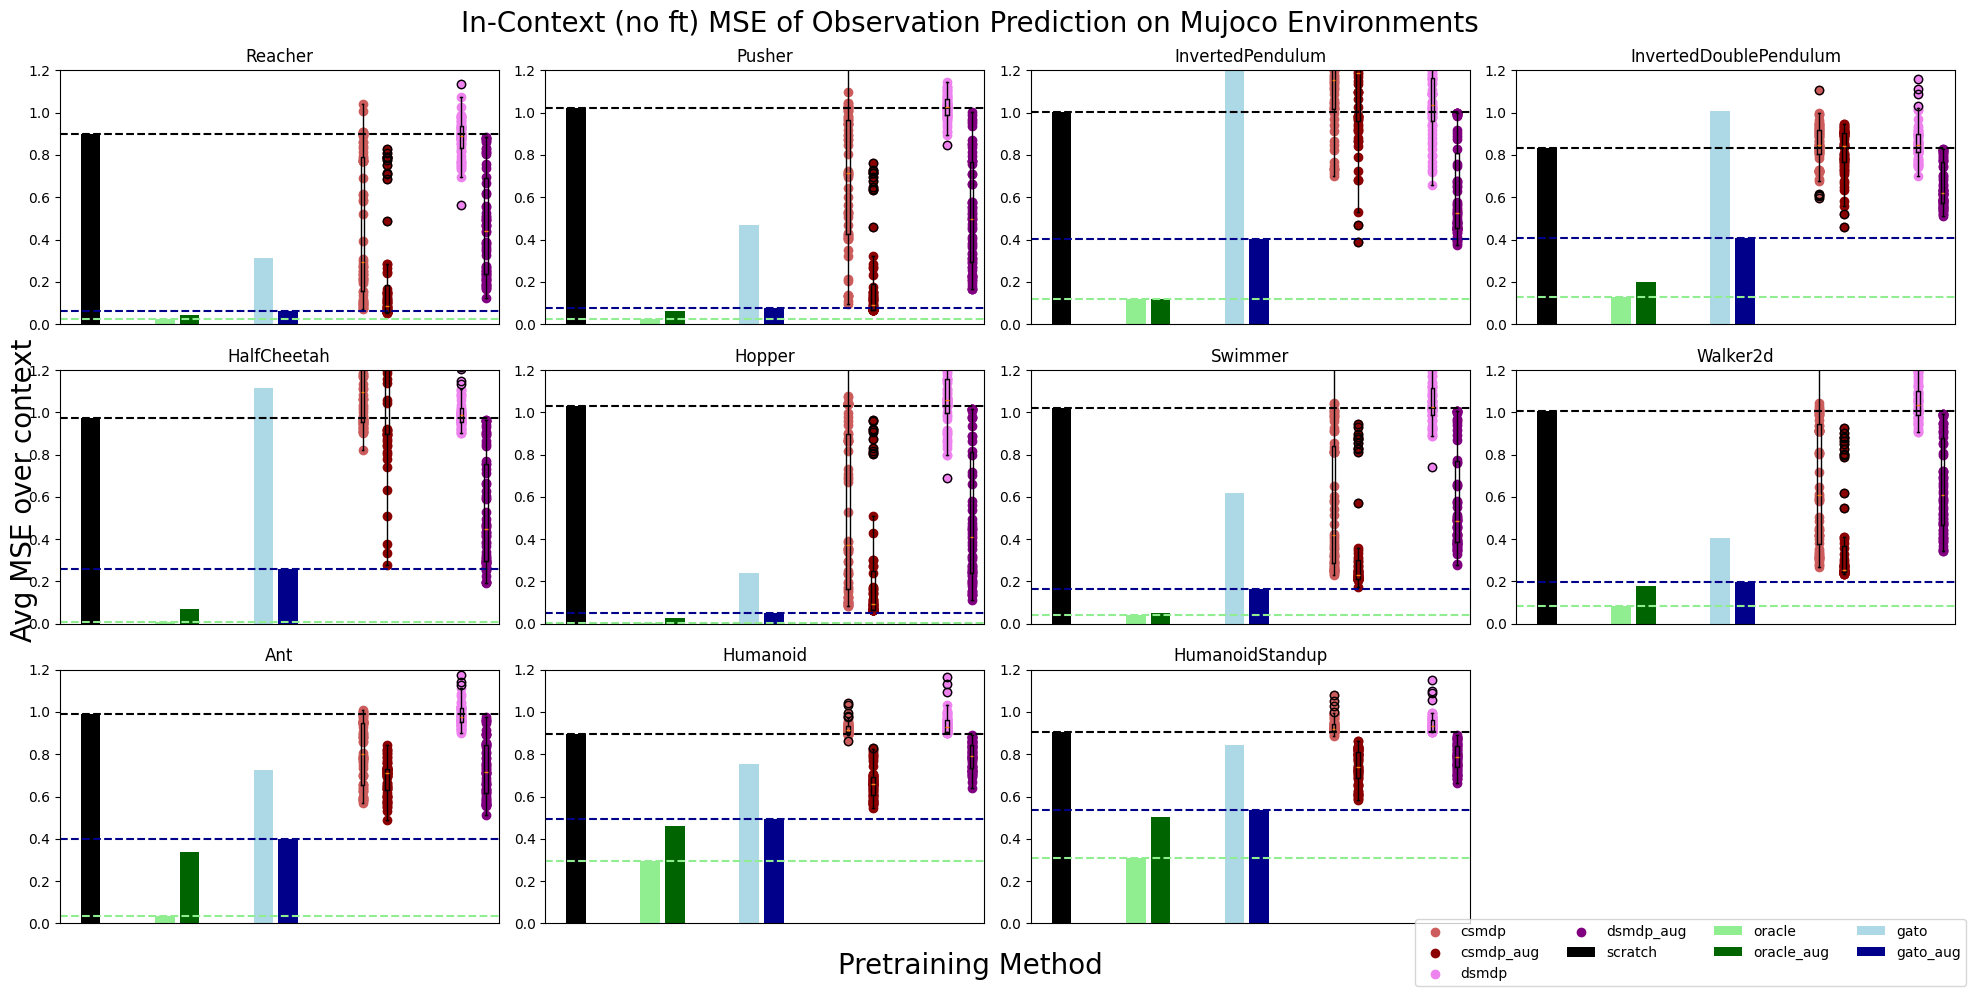

In [106]:
plt.figure(figsize=(20, 10))

key = 'mse_obs'
reduction = lambda x: x.mean(axis=0).mean().item()

for i_plt, env_id in enumerate(tqdm(envs_mujoco)):
    plt.subplot(3, 4, i_plt+1)
    
    label2c = dict(scratch='black', oracle='lightgreen', oracle_aug='darkgreen', gato='lightblue', gato_aug='darkblue',
                   csmdp='indianred', csmdp_aug='darkred', dsmdp='violet', dsmdp_aug='purple')
    
    
    
    a = reduction(data[env_id]['scratch'][key])
    plt.bar(0, a, label='scratch', color=label2c['scratch'])
    plt.axhline(a, linestyle='dashed', color=label2c['scratch'])
    
    a = reduction(data[env_id]['oracle'][key])
    plt.bar(3, a, label='oracle', color=label2c['oracle'])
    plt.axhline(a, linestyle='dashed', color=label2c['oracle'])
    a = reduction(data[env_id]['oracle_aug'][key])
    plt.bar(4, a, label='oracle_aug', color=label2c['oracle_aug'])
    
    a = reduction(data[env_id]['gato'][key])
    plt.bar(7, a, label='gato', color=label2c['gato'])
    a = reduction(data[env_id]['gato_aug'][key])
    plt.bar(8, a, label='gato_aug', color=label2c['gato_aug'])
    plt.axhline(a, linestyle='dashed', color=label2c['gato_aug'])
    
    
    a = []
    for pre in envs_csmdp:
        if data[env_id][pre] is not None:
            a.append(reduction(data[env_id][pre][key]))
    plt.scatter(np.ones(len(a))*11, a, label='csmdp', c=label2c['csmdp'])
    plt.boxplot(a, positions=[11])
    
    a = []
    for pre in [f"{i}_aug" for i in envs_csmdp]:
        if data[env_id][pre] is not None:
            a.append(reduction(data[env_id][pre][key]))
    plt.scatter(np.ones(len(a))*12, a, label='csmdp_aug', c=label2c['csmdp_aug'])
    plt.boxplot(a, positions=[12])

    a = []
    for pre in envs_dsmdp:
        if data[env_id][pre] is not None:
            a.append(reduction(data[env_id][pre][key]))
    plt.scatter(np.ones(len(a))*15, a, label='dsmdp', c=label2c['dsmdp'])
    plt.boxplot(a, positions=[15])

    a = []
    for pre in [f"{i}_aug" for i in envs_dsmdp]:
        if data[env_id][pre] is not None:
            a.append(reduction(data[env_id][pre][key]))
    plt.scatter(np.ones(len(a))*16, a, label='dsmdp_aug', c=label2c['dsmdp_aug'])
    plt.boxplot(a, positions=[16])

    plt.title(env_id)
    # plt.legend()
    
    plt.ylim(0, 1.2)
    # plt.yscale('log')
    plt.xticks([])
    
lines, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(lines, labels, loc='lower right', ncol=4)
plt.gcf().supylabel("Avg MSE over context", fontsize=20)
plt.gcf().supxlabel("Pretraining Method", fontsize=20)
plt.suptitle(f"In-Context (no ft) MSE of {'Action' if key=='mse_act' else 'Observation'} Prediction on Mujoco Environments", fontsize=20)

plt.tight_layout()

plt.show()


In [125]:
a = []
for env_id in envs_mujoco:
    for pre in [f"{i}_aug" for i in envs_csmdp]:
        if data[env_id][pre] is not None:
            a.append(reduction(data[env_id][pre][key]))
        else:
            a.append(np.nan)
a = np.array(a)
a = a.reshape(11, -1)


In [127]:
a.shape

(11, 64)

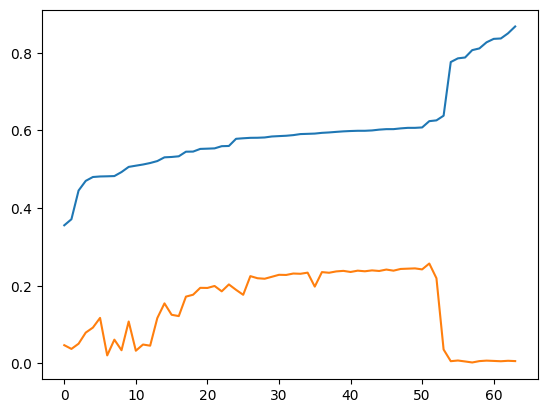

In [131]:
idx = a.mean(axis=0).argsort()
plt.plot(a[:, idx].mean(axis=0))
plt.plot(a[:, idx].var(axis=0))


In [6]:
d = "/data/vision/phillipi/akumar01/cluster_run_logs/2024_03_22_03_11_52"

In [27]:
missing, failed = [], []
for i in tqdm(range(2871)):
    if not os.path.exists(f"{d}/job_{i:05d}.return"):
        missing.append(i)
    else:
        with open(f"{d}/job_{i:05d}.return", "r") as f:
            ret = [line.strip() for line in f.readlines()]
            ret = [line for line in ret if line]
            assert len(ret)==1
            if ret[0]!='0':
                failed.append(i)
            

  0%|          | 0/2871 [00:00<?, ?it/s]

In [28]:
missing

[2855, 2859]

In [25]:
for i in failed:
    print(f"cat job_{i:05d}.log")

cat job_01544.log
cat job_01546.log
cat job_01581.log
cat job_01672.log
cat job_01674.log
cat job_01709.log
cat job_01800.log
cat job_01802.log
cat job_01837.log
cat job_01928.log
cat job_01930.log
cat job_01965.log
cat job_02056.log
cat job_02058.log
cat job_02093.log
cat job_02184.log
cat job_02186.log
cat job_02221.log
cat job_02312.log
cat job_02314.log
cat job_02349.log
cat job_02440.log
cat job_02442.log
cat job_02477.log
cat job_02568.log
cat job_02570.log
cat job_02605.log
cat job_02696.log
cat job_02698.log
cat job_02733.log
cat job_02824.log
cat job_02826.log
cat job_02861.log


In [ ]:
mv oracle_aug temp
mv gato oracle_aug
mv temp gato